# IMG_4458

- **findContours⇨ contours, hierarchy**

<div align='left'><img src="contour_explain.png" width="50%"></div>

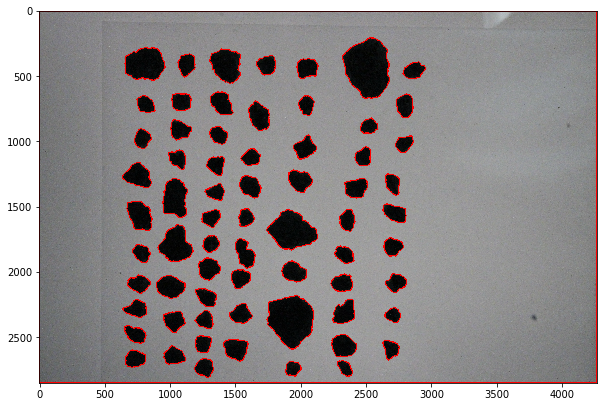

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 17 17:38:06 2020

@author: sayaka71
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# グラフ描画の関数定義
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

# グレー画像
img = cv2.imread('IMG_4458.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# 大津法で2値化 retはbool値
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# ノイズを消す
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 5)

# 確実な背景
sure_bg = cv2.dilate(opening,kernel,iterations=5)

# --- 距離変換　（オブジェクトと背景の距離を出す） ---
# 閾値（距離変換で得られた値の最大値×0.2） ←ここを調節！
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.19*dist_transform.max(), 255, 0)

# 距離変換の結果から確実な前景を
sure_fg = np.uint8(sure_fg)

# 前景でも後景でもないUnknown
unknown = cv2.subtract(sure_bg,sure_fg)


# オブジェクトごとにラベルをつける
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# markersデータをもとにwatershed
markers = cv2.watershed(img, markers)

# contours(輪郭), hierarchy(階層，親子)
contours, hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        # 境界を赤色で描く  (255, 0,　0)： color red,  5pt line
        cv2.drawContours(img, contours, i, (255, 0, 0), 5)
        
display(img)

In [2]:
len(contours)

135

In [3]:
# 外れ値をdelete（あとで外れ値がわかるけど先に削除しとく）
# contours = np.delete(contours, 1678,0)
contours = np.delete(contours, -1,0)

OpenCV公式サイト⇨ [Moment](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html)

In [4]:
from math import sqrt, pi ,acos
from tqdm import tqdm
from scipy.spatial import distance

# 粒子の形状を測定
Areas = []
Perimeters = []
Circularities = []
Eq_diameters = []
Longest = []
Shortest = []
Distance_Gomez = []
degrees = np.arange(0, 2*pi, 2*pi/36) # degrees: 10度ずつで回す (2pi/36 = 10deg)

for cnt in tqdm(contours):
    # 面積 (px*px)
    area = cv2.contourArea(cnt)
    Areas.append(area)
    
    # 周囲長(perimeter)
    arc = cv2.arcLength(cnt, True)
    Perimeters.append(arc)
    # 円形度(circularity)
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # 等価直径(px)
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
    
    # 重心(Moment)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # 重心から輪郭までの距離 (Distance_Gomez)
    for deg in degrees:
        for cnts in cnt:
            # cntの(x,y)座標
            x = cnts[0,0]
            y = cnts[0,1]
            # ユークリッド距離
            d_eu = distance.euclidean((x,y), (cx,cy))
            # 指定角度の方向にある輪郭の点を求める誤差1度まで ( |acos(x-cx) / d_eu| < 1 degree )
            if abs(acos((x-cx)/d_eu) - deg) < pi/360:
                break
            else:
                continue
        # scaling
        d_eu_scaled = d_eu/eq_diameter
        Distance_Gomez.append(d_eu_scaled)
    # Ellipse - shortest, longest ax
    ellipse = cv2.fitEllipse(cnt)
    Shortest.append(ellipse[1][0])
    Longest.append(ellipse[1][1])
            
        

100%|██████████| 134/134 [00:22<00:00,  6.08it/s]


36.0
n = 5.0


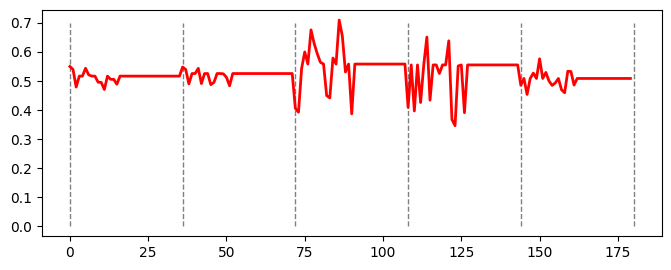

In [5]:
# plot distance (n=5)
print(len(Distance_Gomez)/len(contours))
print(f'n = {len(Distance_Gomez[:180])/36}')

# plot
plt.figure(figsize=(8,3), dpi=100)
plt.plot(np.arange(len(Distance_Gomez[:180])), Distance_Gomez[:180], c='r', lw=2)
# 垂直線 vline
vline = np.arange(0, 181, 36)
for i in vline:
    plt.vlines([i], 0, 0.7, 'gray', linestyle='dashed', lw=1)

Text(0.5, 1.0, 'Distance (All)')

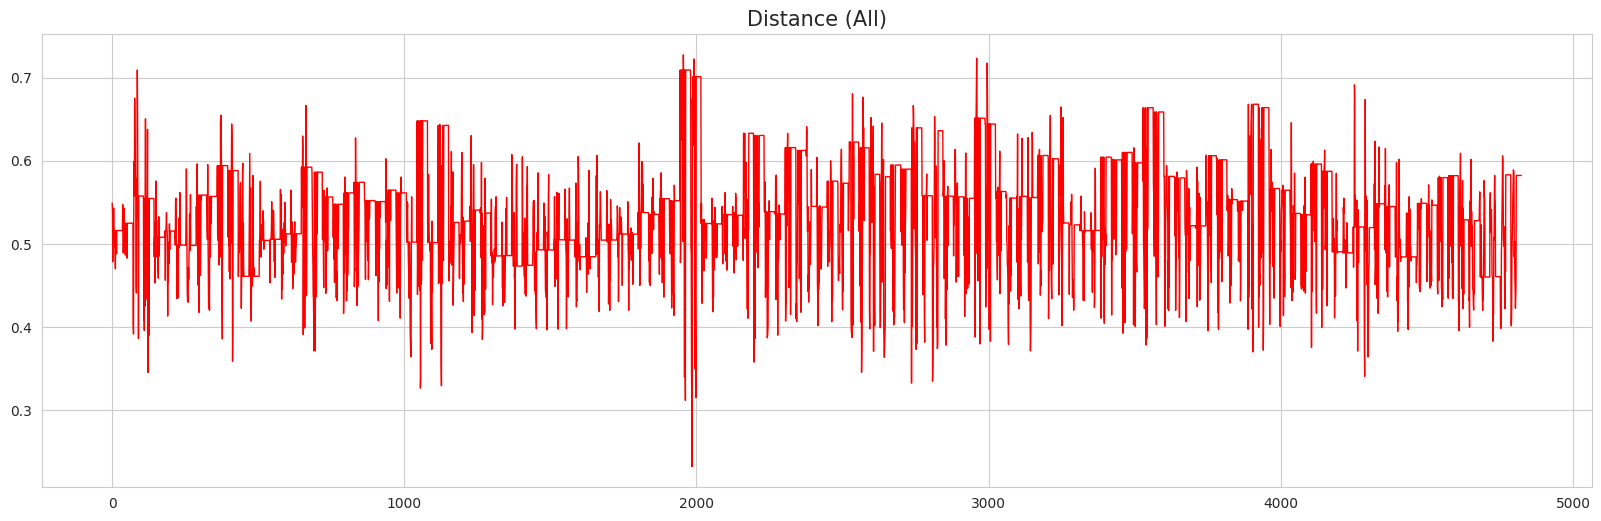

In [6]:
# Distance
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20,6), dpi=100)
plt.plot(np.arange(len(Distance_Gomez)), Distance_Gomez, c='r', lw=1)
plt.title('Distance (All)', {'fontsize':15})

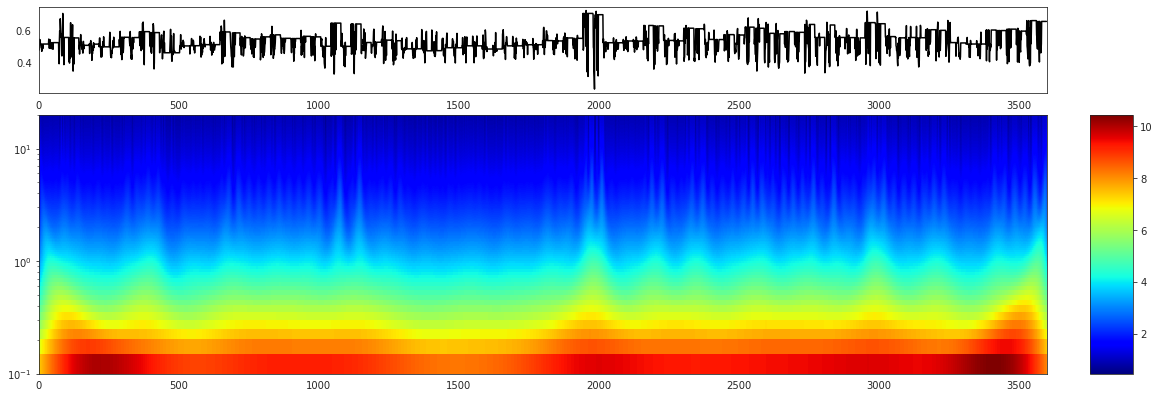

In [7]:
# morlet wavelet n=100 (n=3600/36), omega=0.2

sns.set_style('white')
from swan import pycwt
x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.2

# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

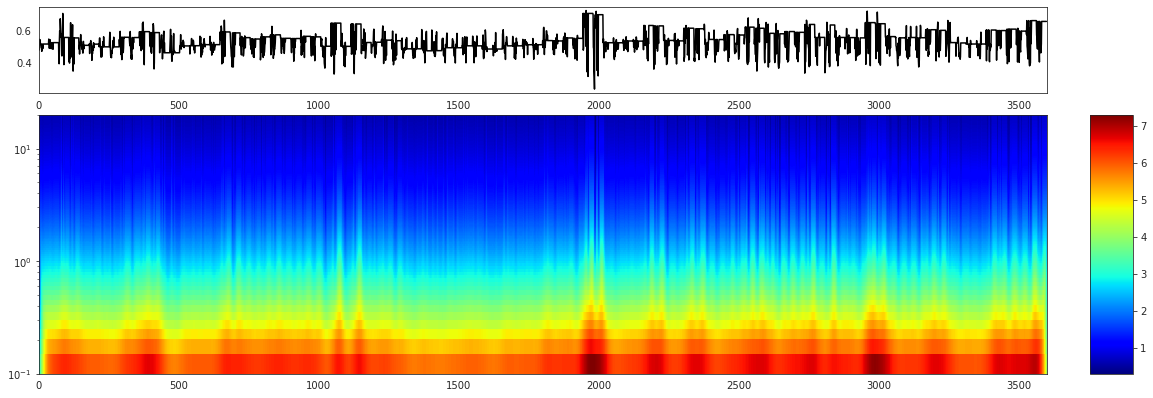

In [8]:
# morlet wavelet n=100 (n=3600/36), omega=0.02

sns.set_style('white')
from swan import pycwt
x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.02

# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

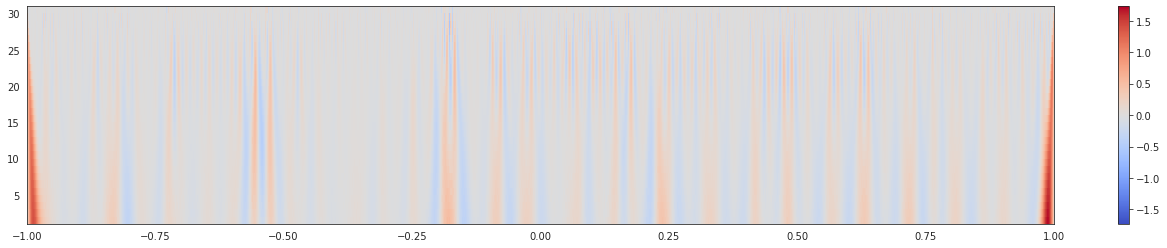

In [9]:
# wavenet n=200 (mexican hat👒)
import pywt
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(Distance_Gomez[:7200], widths, 'mexh')
sns.set_style('white')
plt.figure(figsize=(23, 4))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='coolwarm', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.colorbar();

## DataFrame

In [10]:
import pandas as pd
df = pd.DataFrame({'Areas(px^2)': Areas, 'Circularity': Circularities, 'Equal Diameters(px)': Eq_diameters, 'Shortest Axis(px)': Shortest, 'Longest Axis(px)': Longest, 'Perimeters(px)': Perimeters})

In [11]:
df.head()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Axis(px),Longest Axis(px),Perimeters(px)
0,9685.5,0.724936,111.049366,107.942764,117.756691,409.747253
1,10399.5,0.737110,115.069782,111.162987,121.397118,421.060961
2,8853.0,0.696543,106.169627,82.049446,142.811340,399.646749
3,9541.0,0.709911,110.217868,85.501053,146.410461,410.960457
4,14562.5,0.773765,136.167363,137.939850,139.869675,486.315796


In [12]:
# 外れ値
# df.loc[df['Longest Length(px)'] > 700]
# >>> 1678, 1341
df.loc[df['Longest Axis(px)'] > 300]

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Axis(px),Longest Axis(px),Perimeters(px)
32,102716.0,0.736494,361.638042,343.240662,396.014282,1323.851935
33,104984.0,0.740053,365.608780,346.809998,399.555450,1335.165645
66,74881.5,0.672078,308.775140,279.898834,359.963135,1183.266148
67,76867.5,0.676896,312.842997,283.525848,362.970917,1194.579857
76,42070.0,0.609627,231.441543,185.746170,310.731445,931.234623
78,43682.0,0.617881,235.833945,189.186859,313.942352,942.548331
130,59000.0,0.712223,274.082347,243.529236,312.875977,1020.288445
131,60752.0,0.717375,278.122003,247.603714,315.722473,1031.602152
132,119688.5,0.733338,390.374348,342.693909,454.037415,1432.118961
133,122122.5,0.736567,394.323720,346.193329,457.263489,1443.432670


In [13]:
# df.loc[df['Circularity'] < 0.6]

In [14]:
# df.drop(1678,axis=0, inplace=True)
# df.drop(1341,axis=0, inplace=True)
df.drop([32,33,66,67,76,78,130,131,132,133], inplace=True)

In [15]:
df.describe()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Axis(px),Longest Axis(px),Perimeters(px)
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,17666.774194,0.727949,147.669941,134.563293,169.883825,545.519272
std,7098.675610,0.044508,26.328965,25.586259,33.149205,105.995788
min,8853.000000,0.541447,106.169627,82.049446,114.953644,385.404108
25%,13320.000000,0.706607,130.228830,118.435225,147.098148,477.577467
50%,15691.750000,0.732902,141.348313,129.376160,162.169456,521.650319
75%,19753.375000,0.760731,158.589951,144.380806,182.568729,581.964027
max,49042.000000,0.806901,249.884401,245.358246,275.499878,969.945298


sample number = 134



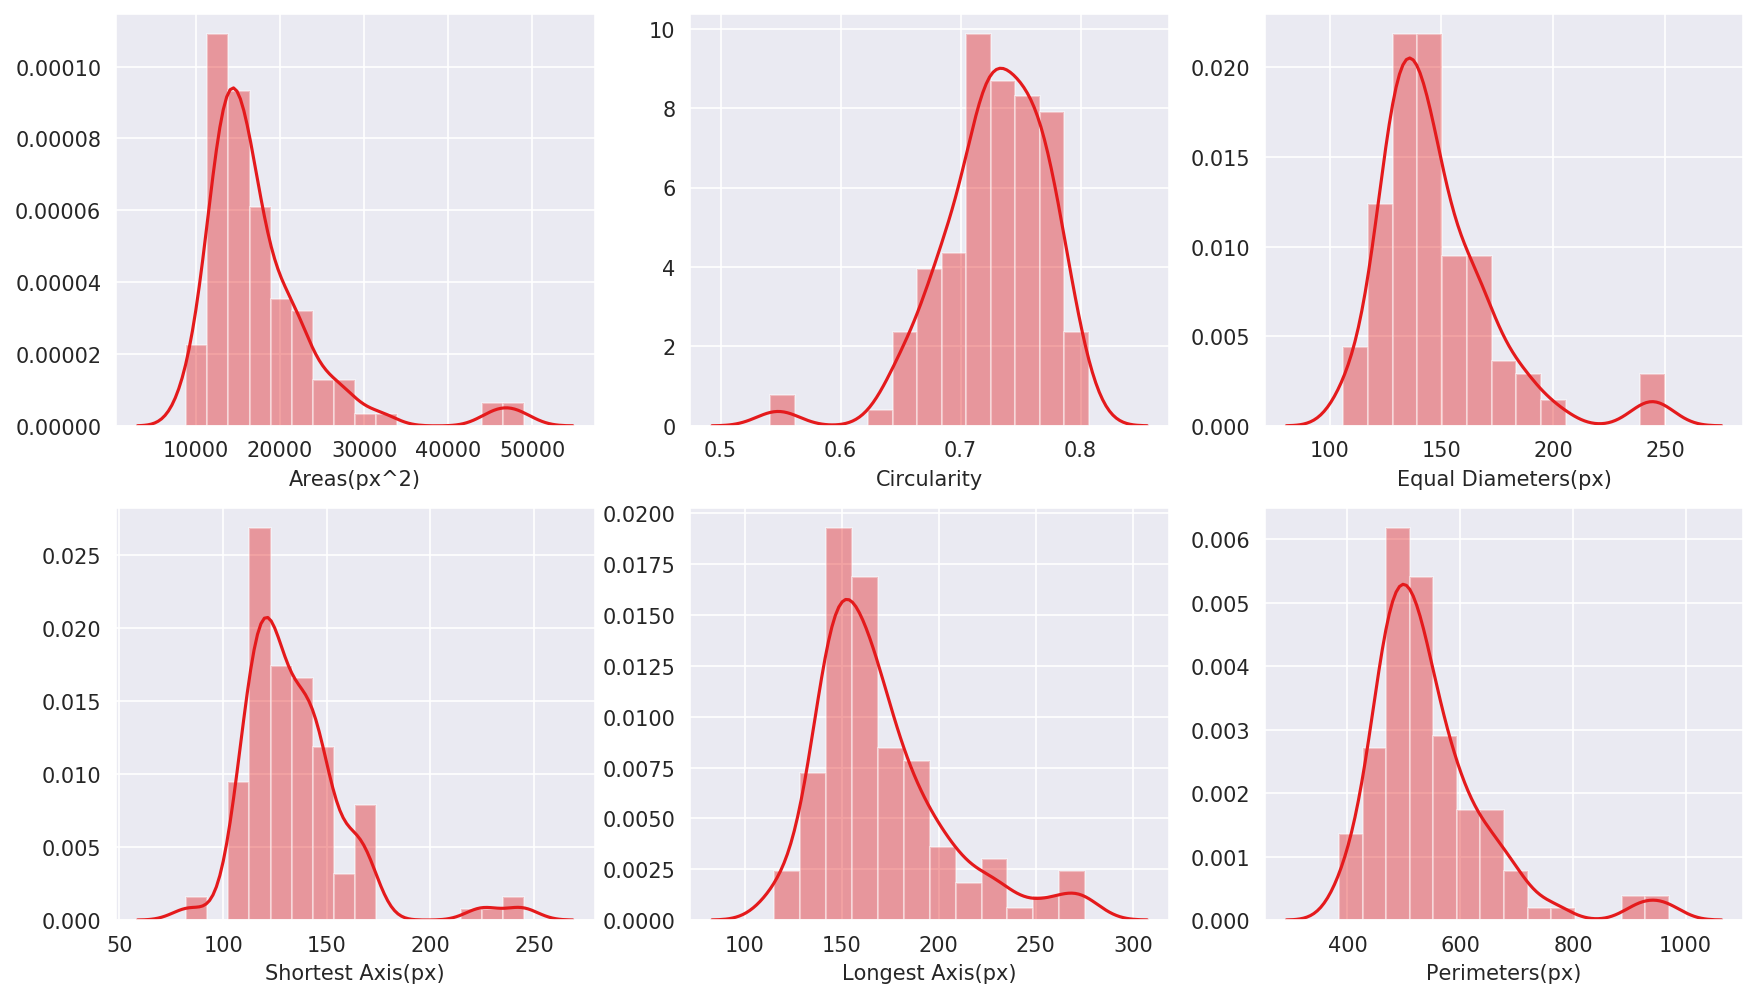

In [16]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set1')
print('sample number = {}\n'.format(len(contours)))
fig, ax = plt.subplots(2,3,figsize=(14,8), dpi=150)

sns.distplot(df['Areas(px^2)'], ax=ax[0,0])
sns.distplot(df['Circularity'], ax=ax[0,1])
sns.distplot(df['Equal Diameters(px)'], ax=ax[0,2])
sns.distplot(df['Shortest Axis(px)'], ax=ax[1,0])
sns.distplot(df['Longest Axis(px)'], ax=ax[1,1])
sns.distplot(df['Perimeters(px)'], ax=ax[1,2]);

# 確率分布
![distribution](Distribution.png)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


Text(0, 0.5, '')

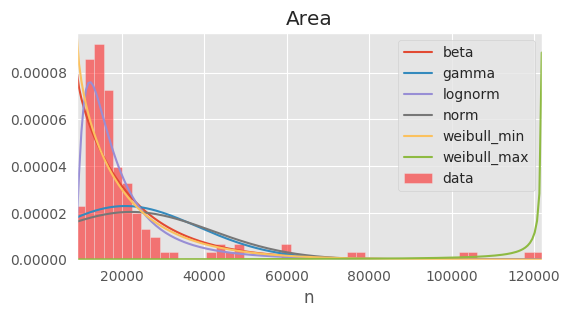

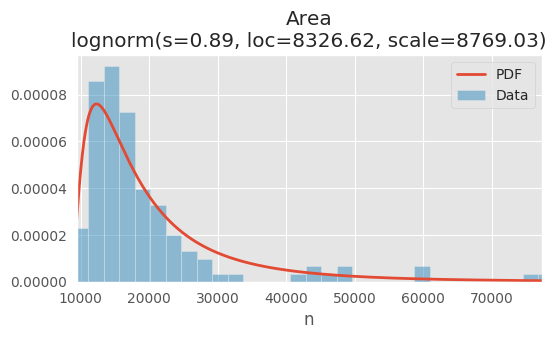

In [20]:
# scriptの更新を反映するおまじない
%load_ext autoreload
%autoreload 2

from functions.pdf import best_fit_distribution, make_pdf, find_PDF

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Load data from statsmodels datasets
data = pd.Series(Areas)

# Plot for comparison
plt.figure(figsize=(6,3), dpi=100)
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='data', legend=True, color='red')
ax.legend(loc='upper right')

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Area')
ax.set_xlabel(u'n')
ax.set_ylabel('')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(6,3), dpi=100)
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Area\n' + dist_str)
ax.set_xlabel(u'n')
ax.set_ylabel('')


In [18]:
# Probability Density Functionをそれぞれ見つける
data_all = [Areas, Circularities, Eq_diameters, Shortest, Longest, Perimeters]
data_name = ['Areas', 'Circularities', 'Eq_diameters', 'Shortest', 'Longest', 'Perimeters']
find_PDF(data_all, data_name)

Areas: lognorm(s=0.89, loc=8326.62, scale=8769.03)
Circularities: beta(a=4512563.51, b=4.74, loc=-93449.00, scale=93449.83)
Eq_diameters: lognorm(s=0.68, loc=100.85, scale=45.83)
Shortest: lognorm(s=0.50, loc=72.22, scale=63.50)
Longest: beta(a=1.79, b=159725482412.58, loc=113.84, scale=6336054485468.96)
Perimeters: lognorm(s=0.70, loc=366.50, scale=173.47)
